## MNIST digit classification using pytorch

Download the MNIST data using pytorch datasets

In [76]:
import torch
import os
from fastai.vision.all import *
from torchvision import datasets

os.getcwd()
data_path = './dataset'
mnist_train_data = datasets.MNIST(data_path, train=True, download=False)
mnist_val_data = datasets.MNIST(data_path, train=False, download=False)

Display the first image in the dataset. The dataset is a collection of PIL image objects

In [77]:
from PIL import Image
img, label = mnist_train_data[0]
display(img)
print(type(img), type(label))
print(f'label = {label}')

<class 'PIL.Image.Image'> <class 'int'>
label = 5


Display 100 images from the training dataset

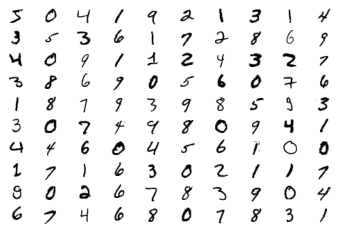

In [78]:
num_images = 100
fig, axs = plt.subplots(10, 10)
for image_index in range(100):
    row_num = int(image_index/10)
    col_num = image_index%10
    img_i, label_i = mnist_train_data[image_index]        
    axs[row_num, col_num].axis('off')
    axs[row_num, col_num].imshow(img_i, cmap='gray_r')    

Use pytorch transforms to convert the PIL image object to a tensor. Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), the ToTensor transform turns the data into a 32-bit floating-point per channel, scaling the values down from 0.0 to 1.0

In [79]:
from torchvision import transforms
to_tensor = transforms.ToTensor()
img_tensor = to_tensor(img)
img_tensor.shape, img_tensor.dtype, img_tensor.min(), img_tensor.max()

(torch.Size([1, 28, 28]), torch.float32, tensor(0.), tensor(1.))

Check the img_tensor to see if the same image is displayed.

<AxesSubplot:>

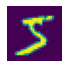

In [80]:
show_image(img_tensor)

Normalize the image data to have zero mean and unit standard deviation. By choosing activation functions that are linear around 0 plus or minus 1 (or 2), keeping the data in the same range means it’s more likely that neurons have nonzero gradients and will learn sooner.

In order to make it so that each channel has zero mean and unitary standard deviation, we can compute the mean value and the standard deviation of each channel across the dataset and apply the following transform: v_n[c] = (v[c] - mean[c]) / stdev[c]. 
This is what transforms.Normalize does. The values of mean and stdev must be computed offline (they are not computed by the transform)

In [81]:
# First convert the image data in pil image object form to tensors
img_tensor_arr = [to_tensor(pil_img) for pil_img, _ in mnist_train_data]
# stack will arrange the tensors one over the other with dim=3 being the new dimension that  stores the number of tensors stacked. This new dimension can be placed at any index
img_stack = torch.stack(img_tensor_arr, dim=3)
print(f'Image tensor stack shape = {img_stack.shape}')
# Now reshape the image tensor stack to have the number of channels ( in our case 1) as the
# first dimension and arrange the remaining elements (28 * 28 = 764) as a 1d vector in the second dimension
img_stack_reshaped = img_stack.view(1, -1)
# Now calculate the mean and std deviation of the reshaped stack across dimension 1 i.e. across
# all the 764 length 1d vectors of 60000 images
img_mean = img_stack_reshaped.mean(dim = 1)
print(f'Mean = {img_mean}')
img_stdev = img_stack_reshaped.std(dim = 1)
print(f'Standard deviation = {img_stdev}')

Image tensor stack shape = torch.Size([1, 28, 28, 60000])
Mean = tensor([0.1307])
Standard deviation = tensor([0.3081])


In [82]:
a = torch.randn([2, 3, 4])
b = torch.randn([2, 3, 4])
stack = torch.stack([a,b], dim=0)
stack_view = stack.view(2, -1)
stack_view.shape

torch.Size([2, 24])

Now initialize a normalize transform with the calculated mean and std dev values and chain it with the To_Tensor transform to get the transformed input image data

In [83]:
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(img_mean, img_stdev)])
train_mnist = datasets.MNIST(data_path, train=True, download=False, transform = data_transform)
val_mnist = datasets.MNIST(data_path, train=False, download=False, transform=data_transform)

Check the first image of the dataset after the transformation

label = 5


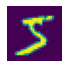

In [84]:
img0, label0 = train_mnist[0]
show_image(img0)
print(f'label = {label0}')

Some more exploration of the transformed training and validation datasets

Number of items in validation set: 10000
Number of items in training set: 60000
(28, 28)
The first image in the validation set


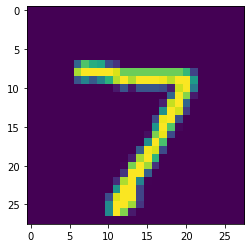

In [85]:
print(f'Number of items in validation set: {len(val_mnist)}')
print(f'Number of items in training set: {len(train_mnist)}')
val_img0 = val_mnist[0][0]
val_img0_np = val_img0.numpy().squeeze()
print(val_img0_np.shape)
print('The first image in the validation set')
plt.imshow(val_img0_np)

Define the model. We use one hidden layer with arbitrary number of units (512). The output layer has 10 units as our problem requires us to classify an image as one of 10 possible images (multi class classification). The input layer has 784 units (28 * 28 pixel image). 

As ours is a multi class classification problem in the output layer we use Softmax as the activation function, the use of softmax activation function is accompanied by the use of negative log likelihood loss function. For details refer:
https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

In [86]:
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1))

print(model)
learning_rate = 0.003
# define the optimizer ( we choose mini batch gradient descent with momentum)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# loss function
loss_fn = nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


Test the model and loss functions defined above are working as expected on one image. We recall that our model expects 784 features in the input, and that nn works with data organized into batches along the zeroth dimension. So we need to turn our 1 × 28 × 28 image into a 1D tensor and then add an extra dimension in the zeroth position using unsqueeze. To start with we use a batch size of 1 image.

In [87]:
out0 = model(img0.view(-1).unsqueeze(0))
print(out0)
loss = loss_fn(out0, torch.tensor([label0]))
print(loss)

tensor([[-2.4119, -2.4277, -2.0986, -2.3336, -2.3616, -2.3149, -2.3371, -2.2799,
         -2.3109, -2.1945]], grad_fn=<LogSoftmaxBackward>)
tensor(2.3149, grad_fn=<NllLossBackward>)


We will be using mini match gradient descent as our optimization algorithm. For this we need to partition our training data into mini batches. Pytorch provides the DataLoader class for exactly this. The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. A very common strategy is uniform sampling after shuffling the data at each
epoch.

In [88]:
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_mnist, batch_size=64, shuffle=True)

The training loop. 

In [89]:
from timeit import default_timer as timer

n_epochs = 10
training_start = timer()
for epoch in range(n_epochs):
    loss_train = 0.0
    start = timer()
    for imgs, labels in train_loader:  
        batch_size = imgs.shape[0]      
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # sum over the losses for all the mini batches in an epoch
        loss_train += loss.item()
    end = timer()
    time_taken = end - start
    # average loss for an epoch = sum of losses over all mini batches / number of mini matches
    avg_epoch_loss = loss_train / len(train_loader)
    print(f'Epoch {epoch} loss = {float(avg_epoch_loss)}, time taken = {time_taken} seconds')    
training_end = timer()
training_time = float((training_end - training_start) / 60)
print(f'Training for {n_epochs} epochs took {training_time} minutes')    

Epoch 0 loss = 0.5353703856436428, time taken = 32.30187719999958 seconds
Epoch 1 loss = 0.20428399151481036, time taken = 26.706774600001154 seconds
Epoch 2 loss = 0.14478426913756615, time taken = 26.117721500000698 seconds
Epoch 3 loss = 0.11378070680118764, time taken = 28.909737199999654 seconds
Epoch 4 loss = 0.09305352494339032, time taken = 28.408825099999376 seconds
Epoch 5 loss = 0.07844314705242893, time taken = 27.584677699998792 seconds
Epoch 6 loss = 0.06744679697612518, time taken = 25.610131100000217 seconds
Epoch 7 loss = 0.058414221432721264, time taken = 26.79022310000073 seconds
Epoch 8 loss = 0.05115310464010659, time taken = 25.163159499999892 seconds
Epoch 9 loss = 0.04427177214454899, time taken = 26.004262899999958 seconds
Training for 10 epochs took 4.5600672233333475 minutes


Let's measure the accuracy of the trained model

In [93]:
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
accuracy = (correct / total) * 100        
print(f"Accuracy: {accuracy}%")

Accuracy: 97.72%
